## Imports

In [12]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import copy
import gymnasium as gym
import pickle
import mujoco

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## states and actions names

In [4]:
state_names = {
    "HalfCheetah": [
        "rootx",
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootx",
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ]
}
action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ]
}

# Helpers

## load model and tokenizer

In [5]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## policy classes

In [6]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [7]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Generate data

## load env, actor, data

In [75]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
algorithm = "ppo"  # sac, ppo, td3

policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ppo_checkpoints__7__1724072335"
# policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__sac_continuous_action__1__1723208574"
# policy_path = "/home/abenechehab/cleanrl/runs/Hopper-v4__sac_continuous_action__1__1723453251"
# policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__td3__1__1723562307"

# policy_checkpoint_list = [10000, 20000, 30000, 40000, 80000, 350000, 700000, 990000]
# policy_checkpoint_list = np.arange(10000, 990000, 10000)
policy_checkpoint = 990000

# load some data to get a pool of states
data_label = "full_replay"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions+1
restarts = X[:, restart_index+1]
episode_starts = np.where(restarts)[0]

# load actor
envs = gym.vector.SyncVectorEnv([make_env(env_name, seed=7, idx=0, capture_video=False, run_name="")])
if algorithm=='sac':
    actor = Actor(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
elif algorithm=='td3':
    actor = TD3Actor(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
else:
    actor = PPOAgent(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/agent_checkpoint_{policy_checkpoint}.pth"))
actor.eval()

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


PPOAgent(
  (critic): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

## rollout

In [76]:
max_episode_length = 1000
context_length = 400
prediction_horizon = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# rollout policy
obs_next, _ = env.reset()
restart = True
df_lines = []
episode_states = []
for step in range(max_episode_length):
    obs = obs_next
    line = []
    line.append(obs[None, ...])
    if 'sac' in policy_path:
        action, _, action_mean, _ = actor.get_action(
            torch.Tensor(obs[None, ...]).to(device)
        )
    elif 'td3' in policy_path:
        action = actor(torch.Tensor(obs[None, ...]).to(device))
        action += torch.normal(0, actor.action_scale * 0.1)
    elif 'ppo' in policy_path:
        action, _, _, _, action_mean, _ = actor.get_action_and_value(
            torch.Tensor(obs[None, ...]).to(device)
        )
    action = action.detach().cpu().numpy().flatten()
    line.append(action[None, ...])
    env_state = get_mujoco_state(env)
    obs_next, reward, terminated, truncated, _ = env.step(action)
    line.append(np.array([reward])[None, ...])
    line.append(np.array([int(restart)])[None, ...])
    line = np.concatenate(line, axis=1)
    df_lines.append(line)
    restart = False
    episode_states.append((obs_next, get_mujoco_state(env)))
    if terminated or truncated:
        break

assert len(df_lines) > context_length, "Error"

data = np.concatenate(df_lines, axis=0)

print(f"data shape: {data.shape}")

init_index = 0

time_series = data[
    init_index : init_index + context_length, :n_observations
]

print(f"time_series shape: {time_series.shape}")

data shape: (1000, 25)
time_series shape: (400, 17)


# ICL

In [77]:
from llmicl.interfaces import trainers


rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series),
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)

trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:33<00:00,  1.96s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:446: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


# Groundtruth distribution

In [78]:
timestep = context_length-1

obs, env_state = episode_states[init_index+timestep-1]
obs_next, _ = episode_states[init_index+timestep]

# policy dist parameters
if algorithm=='sac':
    print(f'shape: {torch.Tensor(obs).to(device).shape}')
    _, _, mean, std = actor.get_action(torch.Tensor(obs[None, ...]).to(device))
elif algorithm=='td3':
    mean = actor(torch.Tensor(obs[None, ...]).to(device))
    std = actor.action_scale * 0.1  # 0.1 is exploitation_noise
else:
    _, _, _, _, mean, std = actor.get_action_and_value(torch.Tensor(obs[None, ...]).to(device))

mean = mean.cpu().detach().numpy()
std = std.cpu().detach().numpy()

# Number of samples
num_samples = 10000

# Sample actions from the policy
next_states = []
for _ in range(num_samples):
    action = np.random.normal(mean, std)
    set_mujoco_state(env, env_state)
    next_state, _, _, _, _ = env.step(action.flatten())
    next_states.append(next_state)

# Convert to numpy array for easier manipulation
next_states = np.array(next_states)

## plot for one state defined by timestep

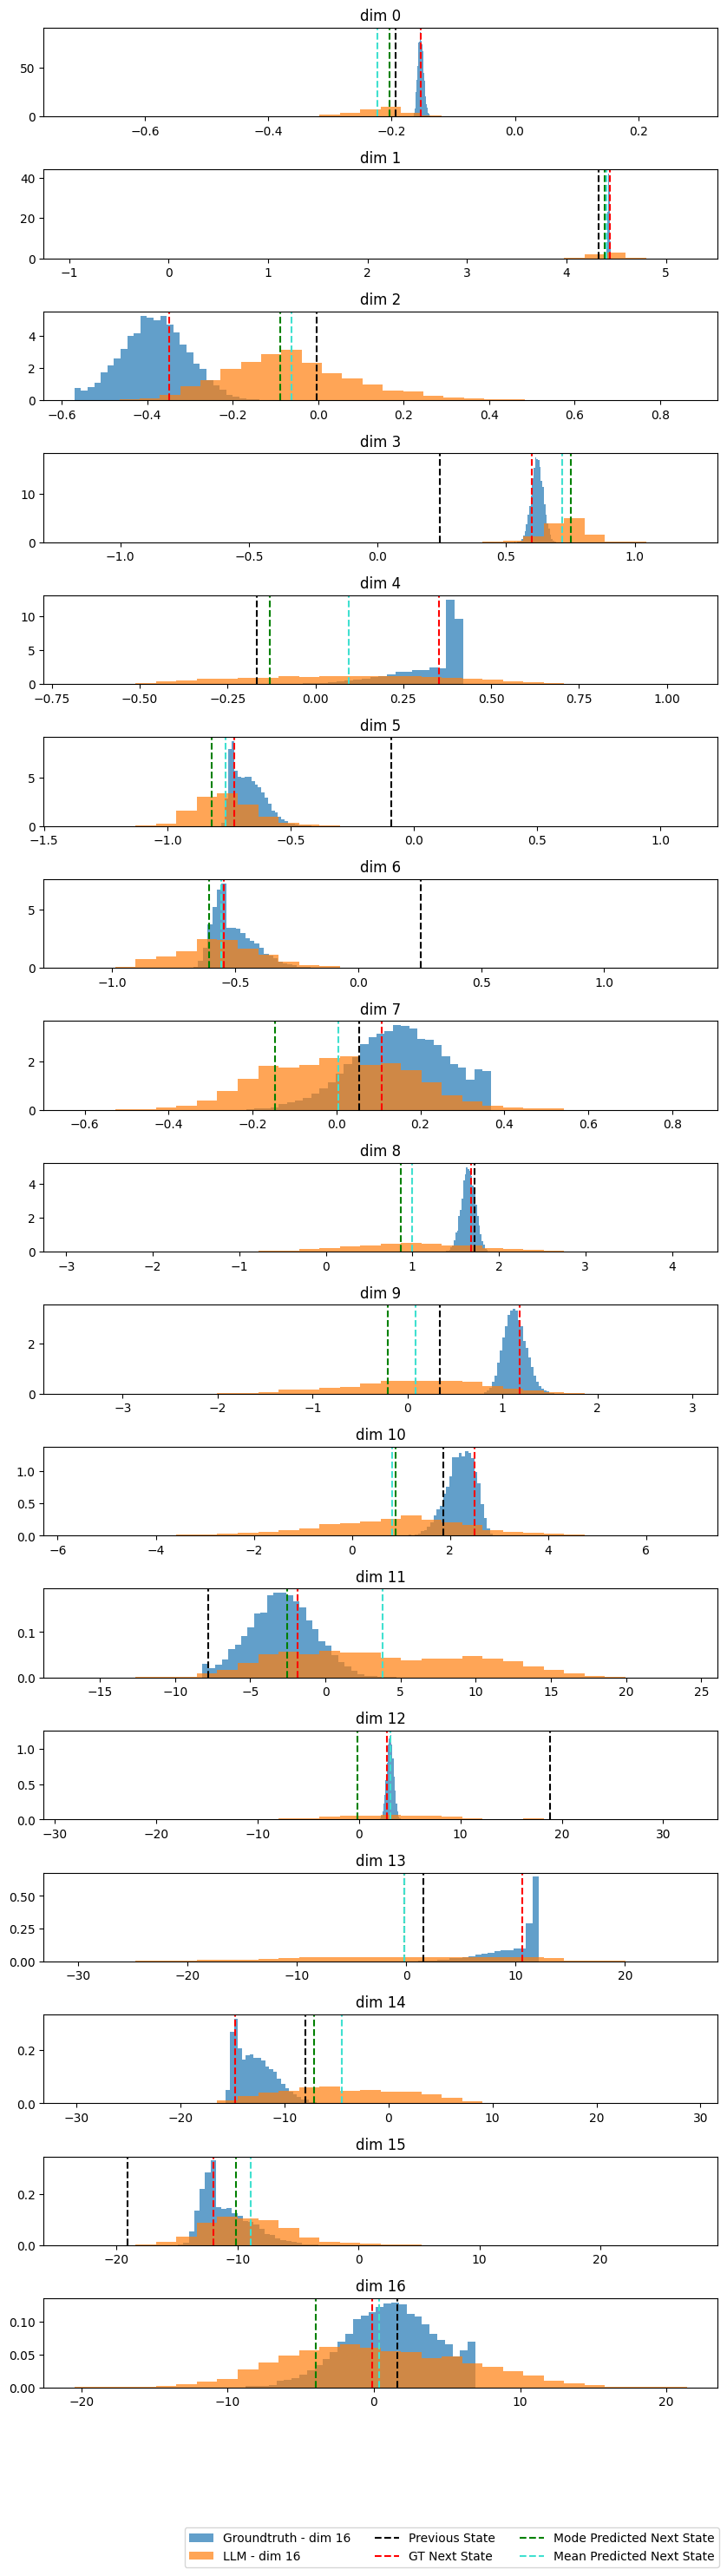

In [79]:
# Plot histogram of the next states
plt.figure(figsize=(10, 30))
for dim in range(next_states.shape[1]):
    groundtruth = data[init_index+1:init_index+context_length+1, dim].flatten()
    
    PDF = icl_object[dim].PDF_list[timestep]
    
    ts_min = icl_object[dim].rescaling_min
    ts_max = icl_object[dim].rescaling_max
    
    bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)

    llm_next_states = np.random.choice(
        bin_center_arr,
        p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
        size=(num_samples,)
    )

    # mode and mean predictions
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    
    plt.subplot(next_states.shape[1], 1, dim + 1)
    
    plt.hist(next_states[:, dim], bins=30, alpha=0.7, label=f'Groundtruth - dim {dim}', density=True)
    plt.hist(llm_next_states, bins=30, alpha=0.7, label=f'LLM - dim {dim}', density=True)
    # plt.bar(bin_center_arr, bin_height_arr, alpha = 1.0, label=f'LLM', color='green')
    plt.axvline(x=obs[dim], color='k', linestyle='--', label='Previous State')
    plt.axvline(x=groundtruth[timestep], color='r', linestyle='--', label='GT Next State')
    plt.axvline(x=mode_arr[timestep], color='green', linestyle='--', label='Mode Predicted Next State')
    plt.axvline(x=mean_arr[timestep], color='turquoise', linestyle='--', label='Mean Predicted Next State')
    
    # plt.xlim([X[:,dim].min(), X[:,dim].max()])

    plt.title(f"dim {dim}")

plt.legend(loc='center left', bbox_to_anchor=(0.2, -1.8), ncols=3)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legends

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the legend

plt.show()

# Vizu: old plot - true errors Vs groundtruth aleatoric uncertainty Vs learned uncertainty

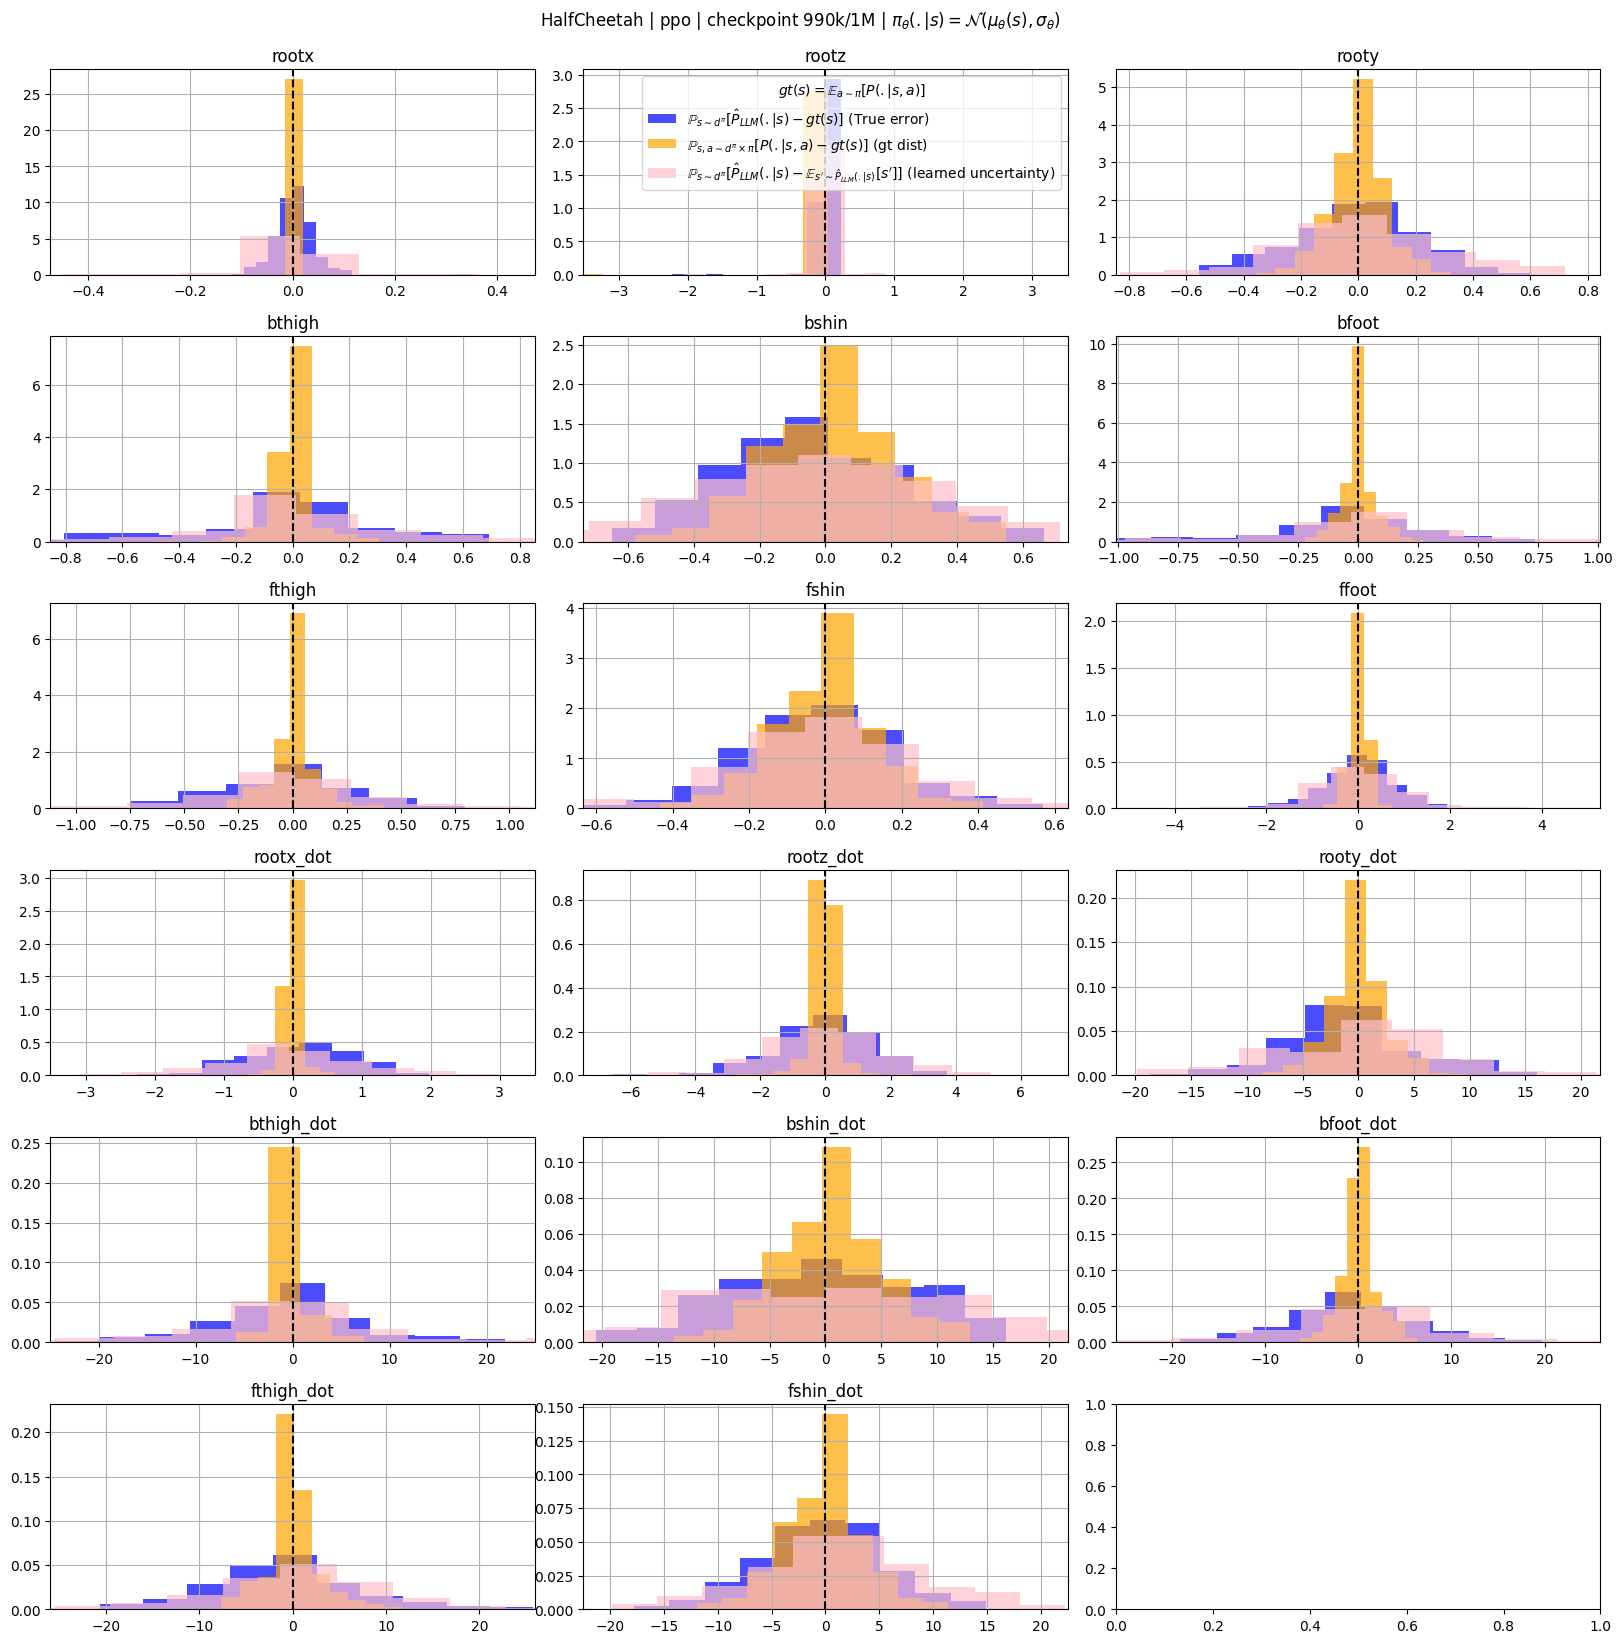

In [84]:
# groundtruth distribution
next_states = []
for t in range(len(episode_states)):
    obs, env_state = episode_states[init_index+t-1]
    obs_next, _ = episode_states[init_index+t]
    
    # policy dist parameters
    if algorithm=='sac':
        _, _, mean, std = actor.get_action(torch.Tensor(obs[None, ...]).to(device))
    elif algorithm=='td3':
        mean = actor(torch.Tensor(obs[None, ...]).to(device))
        std = actor.action_scale * 0.1  # 0.1 is exploitation_noise
    else:
        _, _, _, _, mean, std = actor.get_action_and_value(torch.Tensor(obs[None, ...]).to(device))
    
    mean = mean.cpu().detach().numpy()
    std = std.cpu().detach().numpy()
    
    action = np.random.normal(mean, std)
    set_mujoco_state(env, env_state)
    next_state, _, _, _, _ = env.step(action.flatten())
    next_states.append(next_state[None, ...])
next_states = np.concatenate(next_states, axis=0)

# epistemic uncertainty (from LLM logits)
llm_next_states = []
for t in range(len(icl_object[0].PDF_list)):  
    one_sample = []
    for dim in range(next_states.shape[1]):
        PDF = icl_object[dim].PDF_list[t]
        
        ts_min = icl_object[dim].rescaling_min
        ts_max = icl_object[dim].rescaling_max
        
        bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)
    
        one_sample.append(
            np.random.choice(
                bin_center_arr,
                p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
            )
        )
    llm_next_states.append(np.array(one_sample)[None,...])
llm_next_states = np.concatenate(llm_next_states, axis=0)

f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.1, 'hspace':0.3})
axes = list(np.array(axes).flatten())
for dim in range(next_states.shape[1]):
    groundtruth = data[init_index+1:init_index+context_length+1, dim].flatten()

    ts_min = icl_object[dim].rescaling_min
    ts_max = icl_object[dim].rescaling_max
    
    # mode and mean predictions
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min

    #true error
    error_mode = groundtruth - mode_arr
    error_mean = groundtruth - mean_arr

    error_sampling = groundtruth - next_states[init_index:init_index+context_length, dim]
    uncertainty_estimate = mean_arr - llm_next_states[:, dim]

    start_from = 0

    legend_pred = r"$\mathbb{P}_{s \sim d^\pi}[\hat{P}_{LLM}(.|s) - gt(s)]$ (True error)"
    legend_gt = r"$\mathbb{P}_{s,a \sim d^\pi \times \pi}[P(.|s,a) - gt(s)]$ (gt dist)"
    legend_uncertainty = r"$\mathbb{P}_{s \sim d^\pi}[\hat{P}_{LLM}(.|s) - \mathbb{E}_{s' \sim \hat{P}_{LLM}(.|s)}[s']]$ (learned uncertainty)"
    axes[dim].hist(error_mean[start_from:], color='blue', alpha=0.7, label=legend_pred, density=True)
    axes[dim].hist(error_sampling[start_from:], color='orange', alpha=0.7, label=legend_gt, density=True)
    axes[dim].hist(uncertainty_estimate[start_from:], color='pink', alpha=0.7, label=legend_uncertainty, density=True)
    axes[dim].axvline(x=0, color='k', linestyle='--')
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    dim_range = (X[:,dim].max() - X[:,dim].min()) / 2
    axes[dim].set_xlim([-dim_range, dim_range])
    if dim==1:
        axes[dim].legend(title=r"$gt(s)=\mathbb{E}_{a \sim \pi}[P(.|s,a)]$")
    axes[dim].grid(True)
fig_title = f'{env_name} | {algorithm} | checkpoint {int(policy_checkpoint/1000)}k/1M '
if algorithm=='sac':
    fig_title += r'| $\pi_\theta(.|s) = \mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$'
elif algorithm=='td3':
    fig_title += r'| $\pi_\theta(.|s) = \mathcal{N}(\mu_\theta(s), \sigma)$'
elif algorithm=='ppo':
    fig_title += r'| $\pi_\theta(.|s) = \mathcal{N}(\mu_\theta(s), \sigma_\theta)$'
else:
    raise NotImplementedError
f.suptitle(fig_title, y=0.91)
# plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/uncertainty|{env_name}_algo|{algorithm}_policy|{policy_checkpoint}.pdf")
plt.show()

# Vizu: Vasilii extension

In [81]:
# Number of samples
num_samples = 100

# groundtruth distribution
std_all_states = []
mean_all_states = []
for t in tqdm(range(len(episode_states)), desc='gt dist'):
    obs, env_state = episode_states[init_index+t-1]
    obs_next, _ = episode_states[init_index+t]
    
    # policy dist parameters
    if algorithm=='sac':
        _, _, mean, std = actor.get_action(torch.Tensor(obs[None, ...]).to(device))
    elif algorithm=='td3':
        mean = actor(torch.Tensor(obs[None, ...]).to(device))
        std = actor.action_scale * 0.1  # 0.1 is exploitation_noise
    else:
        _, _, _, _, mean, std = actor.get_action_and_value(torch.Tensor(obs[None, ...]).to(device))
    
    mean = mean.cpu().detach().numpy()
    std = std.cpu().detach().numpy()
    
    # Sample actions from the policy
    next_states = []
    for _ in range(num_samples):
        action = np.random.normal(mean, std)
        set_mujoco_state(env, env_state)
        next_state, _, _, _, _ = env.step(action.flatten())
        next_states.append(next_state[None, ...])
    
    # Convert to numpy array for easier manipulation
    next_states = np.concatenate(next_states, axis=0)
    std_all_states.append(next_states.std(axis=0)[None, ...])
    mean_all_states.append(next_states.mean(axis=0)[None, ...])
mean_all_states = np.concatenate(mean_all_states, axis=0)
std_all_states = np.concatenate(std_all_states, axis=0)


# epistemic uncertainty (from LLM logits)
llm_std_all_states = []
llm_mean_all_states = []
for t in tqdm(range(len(icl_object[0].PDF_list)), desc='llm dist'):  
    one_sample_mean = []
    one_sample_std = []
    for dim in range(next_states.shape[1]):
        PDF = icl_object[dim].PDF_list[t]
        
        ts_min = icl_object[dim].rescaling_min
        ts_max = icl_object[dim].rescaling_max
        
        bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)
    
        samples = np.random.choice(
            bin_center_arr,
            p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
            size=(num_samples,)
        )
        one_sample_mean.append(samples.mean())
        one_sample_std.append(samples.std())
        
    llm_mean_all_states.append(np.array(one_sample_mean)[None,...])
    llm_std_all_states.append(np.array(one_sample_std)[None,...])

llm_mean_all_states = np.concatenate(llm_mean_all_states, axis=0)
llm_std_all_states = np.concatenate(llm_std_all_states, axis=0)

llm dist: 100%|███████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 474.85it/s]


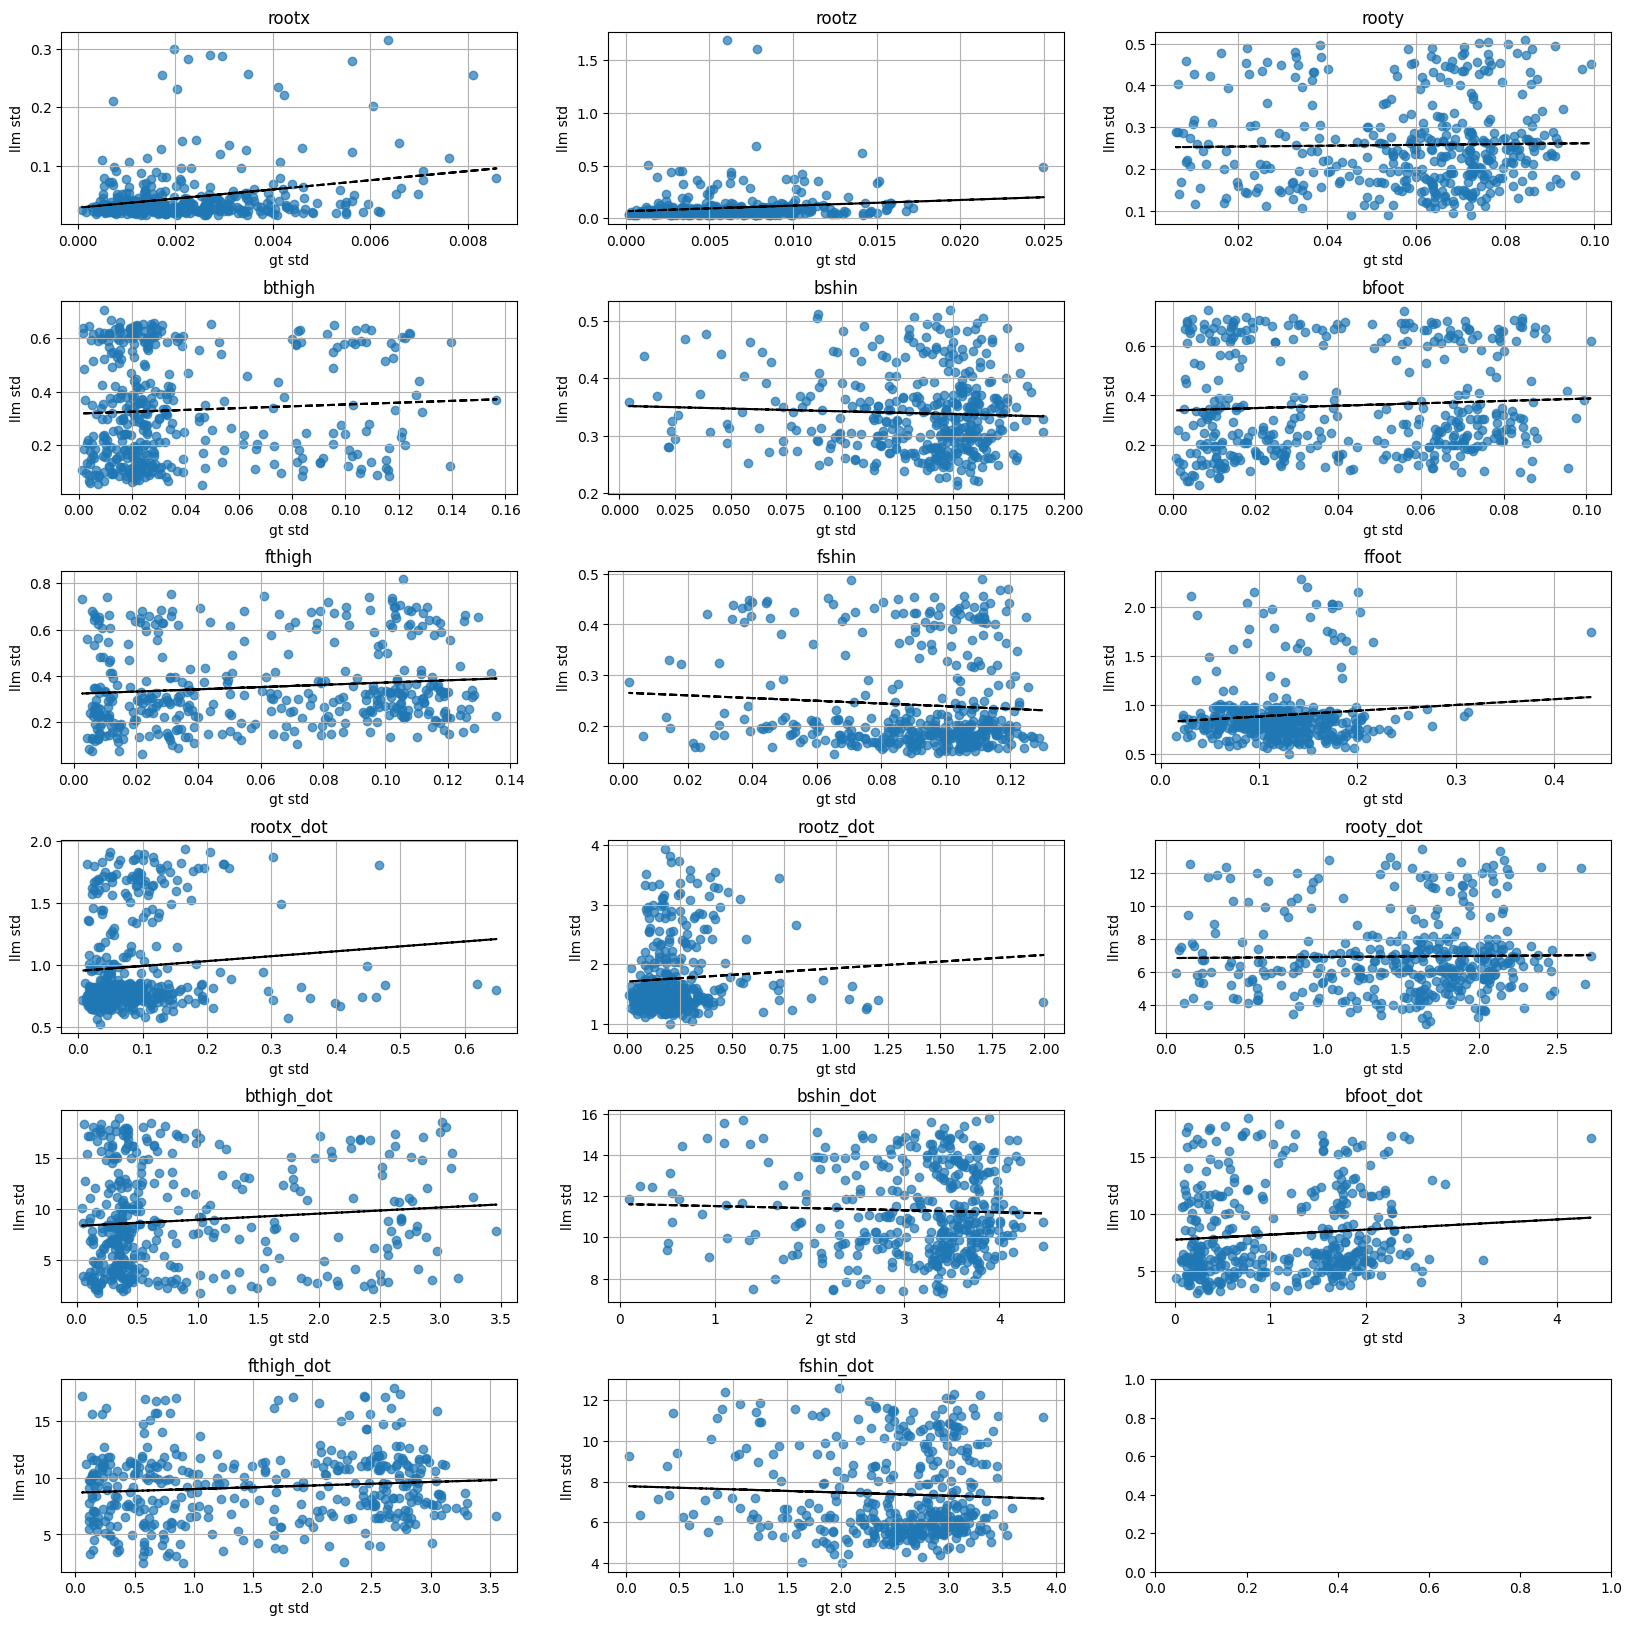

In [83]:
# -------------- plot -------------
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2, 'hspace':0.4})
axes = list(np.array(axes).flatten())
for dim in range(next_states.shape[1]):
    x = std_all_states[init_index:init_index+context_length,dim]
    results = sm.OLS(llm_std_all_states[:,dim],sm.add_constant(x)).fit()
    
    axes[dim].scatter(x, llm_std_all_states[:,dim], alpha=0.7)
    
    axes[dim].plot(x, x * results.params[1] + results.params[0], 'k--')
    
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    axes[dim].grid(True)
    axes[dim].set_xlabel('gt std')
    axes[dim].set_ylabel('llm std')

# fig_title = f'{env_name} | {algorithm} | checkpoint {int(policy_checkpoint/1000)}k/1M '
# f.suptitle(fig_title, y=0.91)
plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/calib_scatter|{env_name}_algo|{algorithm}_policy|{policy_checkpoint}.png")
plt.show()